# **Chess Vision Week 1**

Week 1 (*Model Development and Data Preparation*):

o
Dataset acquisition, exploration, and preprocessing (image normalization, augmentation).

o
Begin the development of the multi-class CNN model architecture.

o
Initiate planning for binary classification models.

# 1. Exploratory Data Analysis
## - Image Distribution
## - Image Count
## - Class Visualization

In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Importing required libraries
!pip install split-folders
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import random
import splitfolders
import cv2
import glob
import csv
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import classification_report

In [3]:
# Setting plot style
plt.style.use('ggplot')

In [4]:
# Paths to Dataset

raw_images_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision"
pre_images_dir = "/content/gdrive/My Drive//Datasets/Chess_Vision_Splitted"
class_names = ["Bishop", "Rook", "Queen", "King", "Knight", "Pawn"]

In [5]:
# Split folders into: Train, Validation and Test

input_folder = "/content/gdrive/My Drive/Datasets/Chess_Vision"
output_folder = "/content/gdrive/My Drive/Datasets/Chess_Vision_Splitted"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .2, .1))

Copying files: 556 files [08:22,  1.11 files/s]


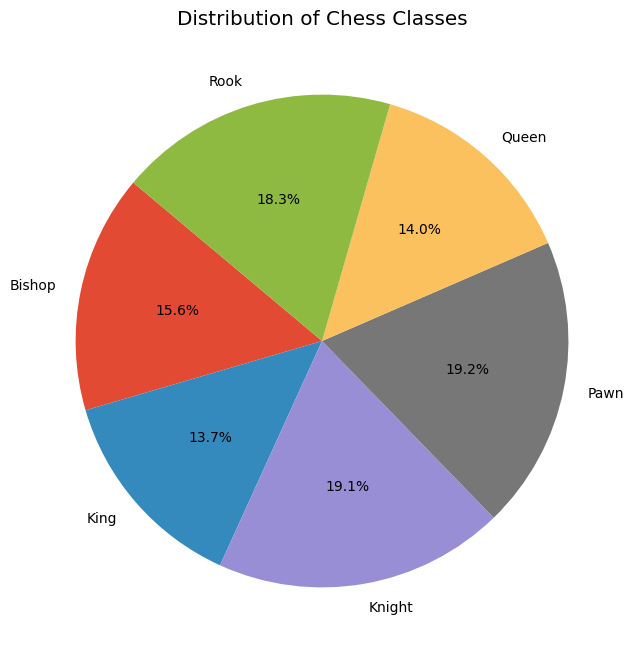

test  train  val


In [6]:
# Image Distribution

# Correct the path to match your dataset's location
class_names = ["Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]

# Get the number of images for each class
image_counts = [len(os.listdir(os.path.join(raw_images_dir, class_name))) for class_name in class_names]

# Create a pie chart of the class distribution
plt.figure(figsize=(8, 8))
plt.pie(image_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Chess Classes")
plt.show()

!ls "/content/gdrive/My Drive/Datasets/Chess_Vision_Splitted"

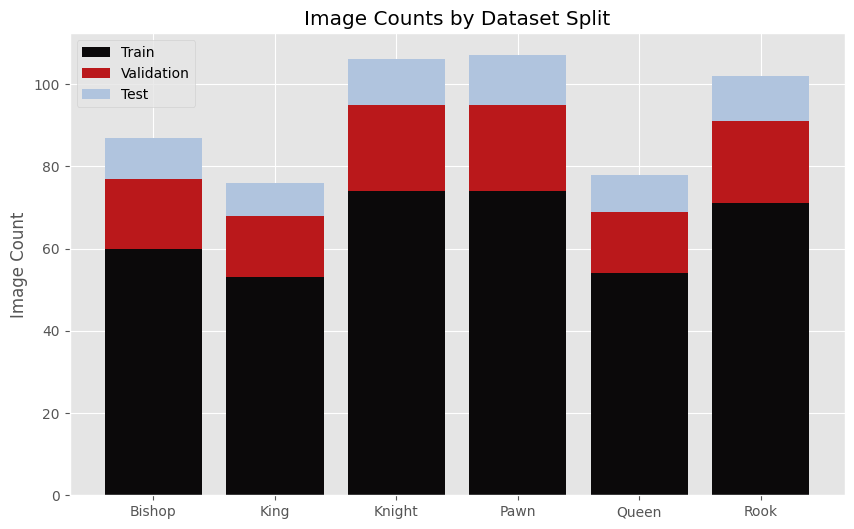

In [7]:
# Image count

pre_images_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision_Splitted"

train_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "train", class_name))) for class_name in class_names]
val_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "val", class_name))) for class_name in class_names]
test_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "test", class_name))) for class_name in class_names]

# Stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(class_names, train_image_counts, color='#0b090a', label='Train')
ax.bar(class_names, val_image_counts, bottom=train_image_counts, color='#ba181b', label='Validation')
ax.bar(class_names, test_image_counts, bottom=np.add(train_image_counts, val_image_counts), color='#b0c4de', label='Test')

plt.ylabel('Image Count')
plt.title('Image Counts by Dataset Split')
plt.legend()
plt.show()

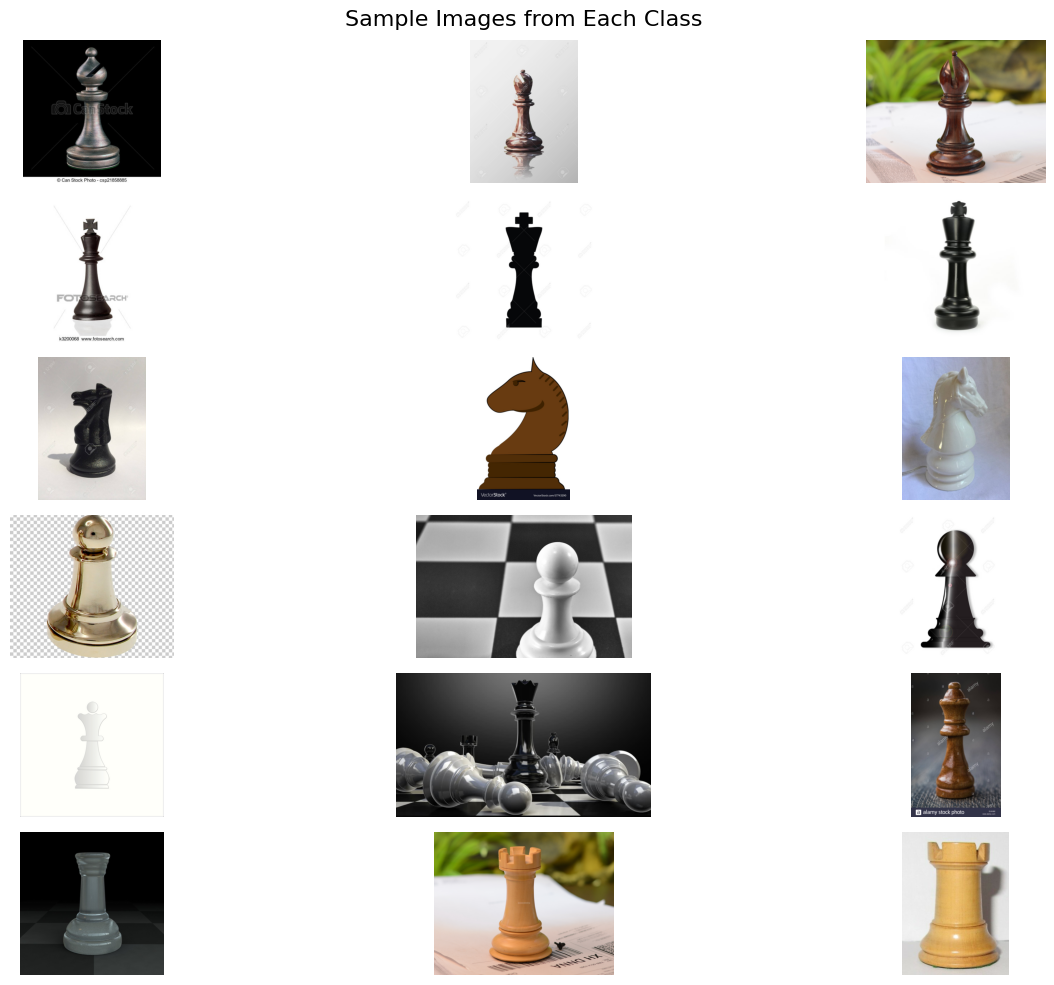

In [10]:
# Class Visualization
import matplotlib.image as mpimg
# Set the number of samples per class to display
samples_per_class = 3

# Plotting multiple samples for each class
fig, axes = plt.subplots(nrows=len(class_names), ncols=samples_per_class, figsize=(15, 10))

for i, class_name in enumerate(class_names):
    image_files = os.listdir(os.path.join(raw_images_dir, class_name))
    sampled_images = random.sample(image_files, samples_per_class)
    for j, image in enumerate(sampled_images):
        img_path = os.path.join(raw_images_dir, class_name, image)
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(class_name)

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

# 2. Image Preprocessing
## - Image Resize
## - Datasets

In [11]:
# Image Resize

# Setting the path for preprocessed dataset
pre_images_dir = "/content/gdrive/My Drive/Datasets/Chess_Vision_Splitted"

# Define the standard size to which all images will be resized
IMG_SIZE = (224, 224)

# Load datasets using image_dataset_from_directory
train_data = image_dataset_from_directory(
    directory=os.path.join(pre_images_dir, 'train'),
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    seed=42)

val_data = image_dataset_from_directory(
    directory=os.path.join(pre_images_dir, 'val'),
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    seed=42)

test_data = image_dataset_from_directory(
    directory=os.path.join(pre_images_dir, 'test'),
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    shuffle=False,  # Important for evaluation
    seed=42)


Found 383 files belonging to 6 classes.
Found 108 files belonging to 6 classes.
Found 61 files belonging to 6 classes.


# 2. Model
## - Base Model with Data Augmentation
## - Callbacks
## - Model Training

In [12]:
# Base Model

# Data Augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal', seed=42),
  preprocessing.RandomRotation(0.2, seed=42),
  preprocessing.RandomHeight(0.2, seed=42),
  preprocessing.RandomWidth(0.2, seed=42),
  preprocessing.RandomZoom(0.2, seed=42)
])

# Load VGG19 model without the top layer
base_model = VGG19(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Define the input layer
inputs = layers.Input(shape=(224, 224, 3))

# Apply data augmentation to the image
x = data_augmentation(inputs)

# Normalize the image
x = layers.Rescaling(1./255)(x)

# Pass the image through the base model
x = base_model(x, training=False)

# Additional layers
x = layers.Dropout(0.4)(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.6)(x)

# Output layer
outputs = layers.Dense(6, activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


80134624/80134624 [==============================] - 3s 0us/step


In [13]:
# Callbacks

# Callback to save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    '/content/gdrive/My Drive/Datasets/Model Checkpoint/checkpoint.h5',
    save_best_only=True,
    monitor="val_accuracy")

# Callback to reduce the learning rate when the validation accuracy stops improving
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=3,
    min_lr=1e-7)

# Callback to log training history to a CSV file
csv_logger = CSVLogger('/content/gdrive/My Drive/Datasets/Training Logs/training_log.csv')

import os

# Create the directory for training logs if it doesn't exist
log_dir = '/content/gdrive/My Drive/Datasets/Training Logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Callback to log training history to a CSV file
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(log_dir, 'training_log.csv'))



In [ ]:
# Simplified base model to test workflow

simplified_model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(6, activation='softmax')
])
# Take a subset of training and validation data
train_data_subset = train_data.take(2)  # Takes only 2 batches
val_data_subset = val_data.take(1)  # Takes only 1 batch


simplified_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = simplified_model.fit(train_data_subset, epochs=10, validation_data=val_data_subset)


In [14]:
# Running the base model

history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=[model_checkpoint, reduce_lr, csv_logger])

Epoch 1/15
12/12 [==============================] - ETA: 0s - loss: 3.7043 - accuracy: 0.1697 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 488s 41s/step - loss: 3.7043 - accuracy: 0.1697 - val_loss: 1.7797 - val_accuracy: 0.1944 - lr: 0.0010
Epoch 2/15
12/12 [==============================] - 449s 39s/step - loss: 1.7823 - accuracy: 0.1697 - val_loss: 1.7843 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 3/15
12/12 [==============================] - 371s 31s/step - loss: 1.7588 - accuracy: 0.2402 - val_loss: 1.7399 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 4/15
12/12 [==============================] - 443s 37s/step - loss: 1.7081 - accuracy: 0.3029 - val_loss: 1.5939 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 5/15
12/12 [==============================] - 417s 34s/step - loss: 1.5531 - accuracy: 0.3786 - val_loss: 1.4436 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 6/15
12/12 [==============================] - 440s 37s/step - loss: 1.4050 - accuracy: 0.4778 - val_loss: 1.2288 - val_accuracy: 0.5463 - lr: 0.0010
Epoch 7/15
12/12 [==============================] - 407s 35s/step - loss: 1.2330 

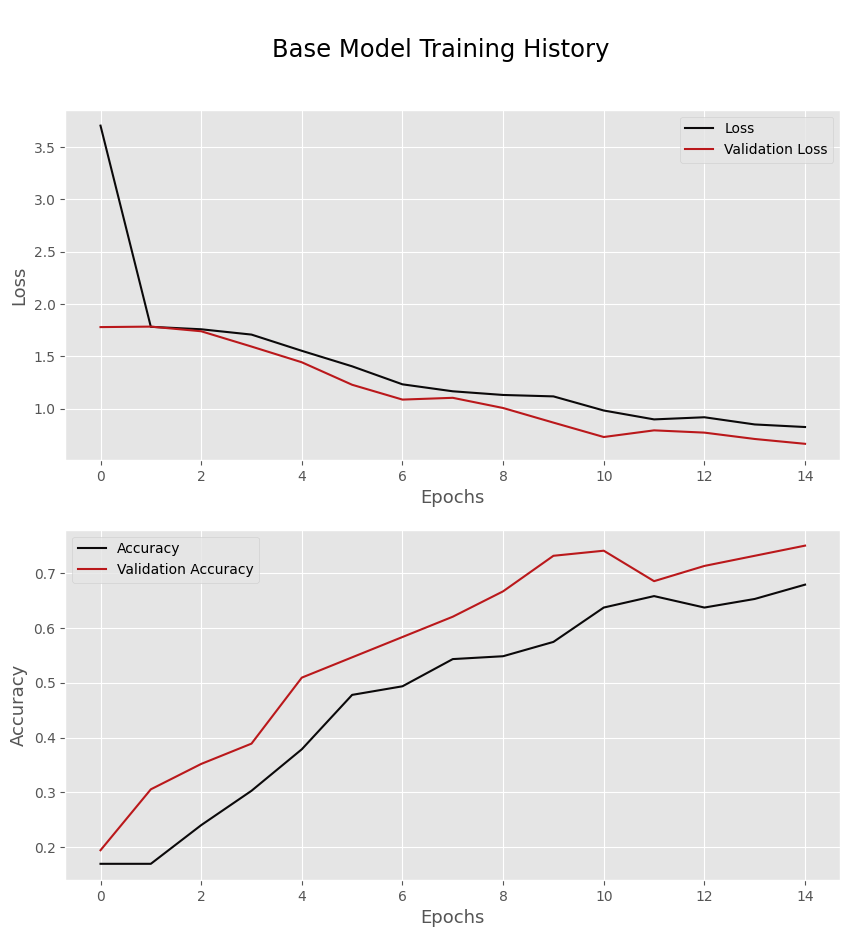

In [15]:
# Base Model Performance

# Plot the training history using two subplots (for loss and accuracy)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

fig.suptitle("\nBase Model Training History", fontsize=17.5)

ax[0].plot(history.history['loss'], label='Loss', color="#0B090A")
ax[0].plot(history.history['val_loss'], label='Validation Loss', color="#BA181B")
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].set_xlabel('Epochs', fontsize=13)
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Accuracy', color="#0B090A")
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color="#BA181B")
ax[1].set_xlabel('Epochs', fontsize=13)
ax[1].set_ylabel('Accuracy', fontsize=13)
ax[1].legend()

plt.show()

In [ ]:
# Simplified Fine Tuned Model to test workflow

# Make the entire model trainable for fine-tuning
simplified_model.trainable = True

# Add a couple of additional trainable layers
simplified_model.add(layers.Dense(16, activation='relu'))
simplified_model.add(layers.Dense(6, activation='softmax'))  # 6 classes for your chess pieces

# Compile the model with a lower learning rate for fine-tuning
simplified_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Training the simplified fine-tuned model
fine_tune_history = simplified_model.fit(train_data_subset, epochs=10, validation_data=val_data_subset)



Epoch 1/10
2/2 [==============================] - 13s 2s/step - loss: 1.8586 - accuracy: 0.0469 - val_loss: 1.8575 - val_accuracy: 0.0938
Epoch 2/10
2/2 [==============================] - 10s 2s/step - loss: 1.8257 - accuracy: 0.1562 - val_loss: 1.8467 - val_accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 7s 2s/step - loss: 1.8721 - accuracy: 0.0625 - val_loss: 1.7975 - val_accuracy: 0.1562
Epoch 4/10
2/2 [==============================] - 7s 4s/step - loss: 1.8460 - accuracy: 0.1250 - val_loss: 1.8155 - val_accuracy: 0.1562
Epoch 5/10
2/2 [==============================] - 7s 2s/step - loss: 1.8433 - accuracy: 0.0781 - val_loss: 1.8197 - val_accuracy: 0.1562
Epoch 6/10
2/2 [==============================] - 5s 2s/step - loss: 1.8442 - accuracy: 0.1250 - val_loss: 1.8172 - val_accuracy: 0.2188
Epoch 7/10
2/2 [==============================] - 8s 4s/step - loss: 1.8898 - accuracy: 0.0781 - val_loss: 1.8046 - val_accuracy: 0.1562
Epoch 8/10
2/2 [=======================

In [17]:
# Fine Tuned Model

# Unfreezing the base model entirely
base_model.trainable = True

# Freezing all layers in the base model, except the last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Compiling the model with a lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              metrics=["accuracy"])

# Training the fine-tuned model
fine_tune_history = model.fit(train_data,
                              epochs=5,
                              validation_data=val_data,
                              callbacks=[model_checkpoint, reduce_lr, csv_logger])


Epoch 1/5
12/12 [==============================] - 667s 56s/step - loss: 0.5524 - accuracy: 0.7441 - val_loss: 0.4391 - val_accuracy: 0.8148 - lr: 2.0000e-05
Epoch 2/5
12/12 [==============================] - 694s 59s/step - loss: 0.5441 - accuracy: 0.7467 - val_loss: 0.5096 - val_accuracy: 0.7778 - lr: 2.0000e-05
Epoch 3/5
12/12 [==============================] - 764s 65s/step - loss: 0.5081 - accuracy: 0.7937 - val_loss: 0.4861 - val_accuracy: 0.8056 - lr: 2.0000e-05
Epoch 4/5
12/12 [==============================] - 725s 62s/step - loss: 0.4431 - accuracy: 0.8016 - val_loss: 0.4960 - val_accuracy: 0.7963 - lr: 2.0000e-05
Epoch 5/5
12/12 [==============================] - 734s 64s/step - loss: 0.4254 - accuracy: 0.8433 - val_loss: 0.4445 - val_accuracy: 0.7963 - lr: 4.0000e-06


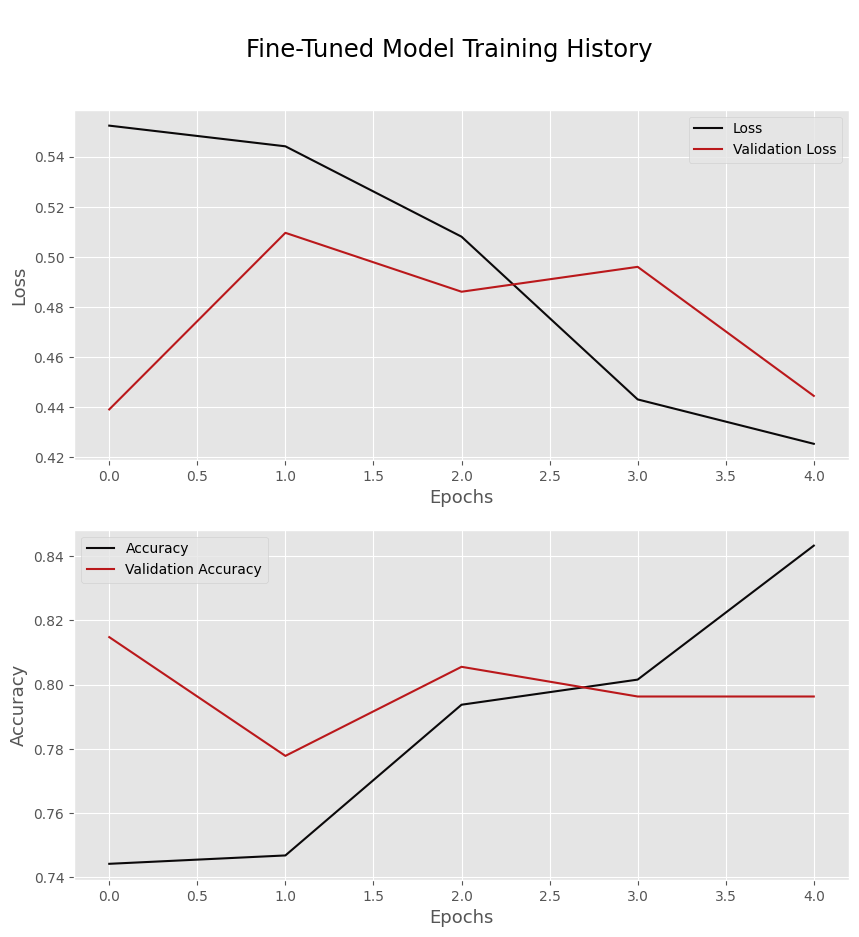

In [18]:
# Fine Tuned Model Performance

# Plot the training history for the fine-tuned model using two subplots (for loss and accuracy)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

fig.suptitle("\nFine-Tuned Model Training History", fontsize=17.5)

ax[0].plot(fine_tune_history.history['loss'], label='Loss', color="#0B090A")
ax[0].plot(fine_tune_history.history['val_loss'], label='Validation Loss', color="#BA181B")
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].set_xlabel('Epochs', fontsize=13)
ax[0].legend()

ax[1].plot(fine_tune_history.history['accuracy'], label='Accuracy', color="#0B090A")
ax[1].plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy', color="#BA181B")
ax[1].set_xlabel('Epochs', fontsize=13)
ax[1].set_ylabel('Accuracy', fontsize=13)
ax[1].legend()

plt.show()


# 4. Evaluation
## - Accuracy
## - Precision, Recall and F!
## - Confusion Matrix

2/2 [==============================] - 62s 30s/step - loss: 0.6006 - accuracy: 0.8197


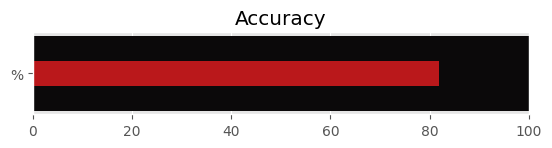

In [19]:
# Accuracy

# Load the best model weights
#model.load_weights('/content/gdrive/My Drive/Datasets/Model Checkpoint/checkpoint.h5')

accuracy = model.evaluate(test_data)[1] * 100

# Plot a horizontal bar plot to represent accuracy
fig, ax = plt.subplots()
ax.barh([1], 100, left=0, height=15, color="#0B090A")
ax.barh([1], accuracy, color="#BA181B", height=5)

ax.set_aspect('equal')
ax.set_yticks([1])
ax.set_yticklabels(['%'])
ax.set_xlim(0, 100)
ax.set(title='Accuracy')

plt.show()

In [ ]:
# Precision, Recall and F1

# Predictions on the test data
test_pred = model.predict(test_data)
test_pred = np.argmax(test_pred, axis=1)

# Extract true labels
test_true = []
for images, labels in test_data.unbatch():
    test_true.append(labels.numpy().argmax())

# Calculate the classification report
report = classification_report(test_true, test_pred, output_dict=True, target_names=class_names)

# Extract precision, recall, and f1-score for each class
class_scores = [[report[class_name][metric] for metric in ["precision", "recall", "f1-score"]] for class_name in class_names]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2
metrics = ["precision", "recall", "f1-score"]

for i, scores in enumerate(class_scores):
    ax.bar(i - bar_width, scores[0], bar_width, color="#0b090a")
    ax.bar(i, scores[1], bar_width, color="#ba181b")
    ax.bar(i + bar_width, scores[2], bar_width, color="#b0c4de")

ax.set_xlabel("Class")
ax.set_ylabel("Scores")
ax.set_ylim(0, 1)
ax.legend(metrics)
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_title("Performance Metrics", fontsize=15)

plt.show()

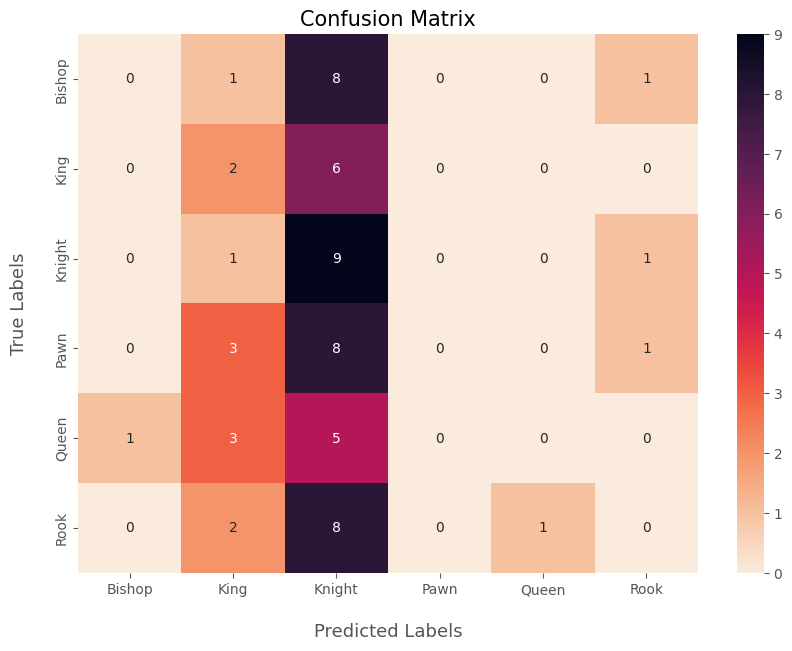

In [ ]:
# Confusion Matrix

# Calculate the confusion matrix
cm = tf.math.confusion_matrix(test_true, test_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='rocket_r', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('\nPredicted Labels', fontsize=13)
ax.set_ylabel('True Labels\n', fontsize=13)
plt.title("Confusion Matrix", fontsize=15)

plt.show()